In [3]:
import torch
from torch import nn 
import torchvision 
from  torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,TensorDataset
import time
import numpy as np

import matplotlib.pyplot as plt 
import icecream as ic
from IPython.display import clear_output,display

train_data = datasets.FashionMNIST(root='data',train=True,download=True,transform=ToTensor(),target_transform=None)
test_data = datasets.FashionMNIST(root='data',train=False,download=True,transform=ToTensor())

device = 'mps'
print(device)
train_loader = DataLoader(train_data,batch_size=128,shuffle=True)
test_loader = DataLoader(test_data,batch_size=128,shuffle=False)






mps


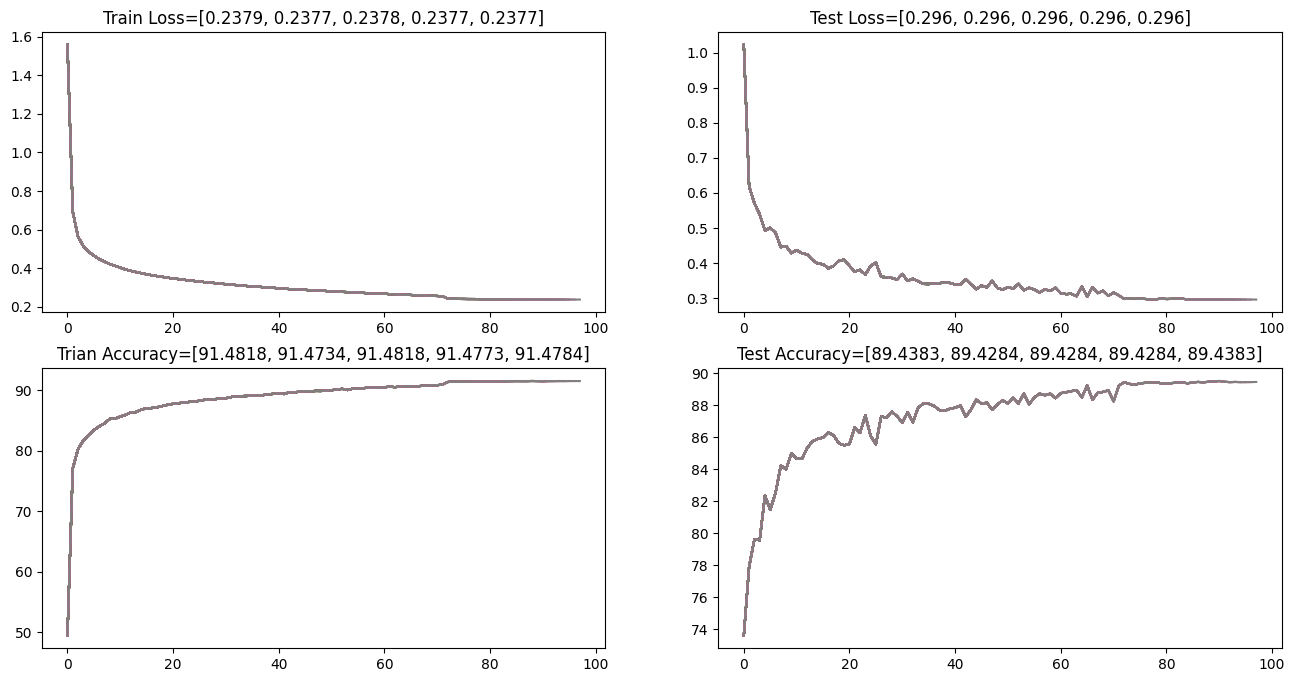

-------epoch------:97 time:9.81s current_lr:1e-05,current_patience:10
Gradient for features.0.weight: 0.07516605406999588
Gradient for features.0.bias: 0.19591529667377472
Gradient for features.2.weight: 0.3015284240245819
Gradient for features.2.bias: 0.20314760506153107
Gradient for features.5.weight: 0.24127227067947388
Gradient for features.5.bias: 0.10249122977256775
Gradient for features.7.weight: 0.3331146538257599
Gradient for features.7.bias: 0.17667633295059204
Gradient for classifier.0.weight: 0.7535470724105835
Gradient for classifier.0.bias: 0.1113254502415657
Gradient for classifier.1.weight: 0.036322735249996185
Gradient for classifier.1.bias: 0.007372021209448576
Gradient for classifier.4.weight: 0.17674770951271057
Gradient for classifier.4.bias: 0.006458477582782507
Early stopping! No improvement for 10 consecutive epochs.
train loss:[1.5571, 0.6929, 0.5636, 0.5151, 0.4854, 0.4652, 0.4478, 0.4343, 0.4212, 0.4123, 0.4029, 0.3935, 0.3866, 0.38, 0.3745, 0.3683, 0.3638, 0

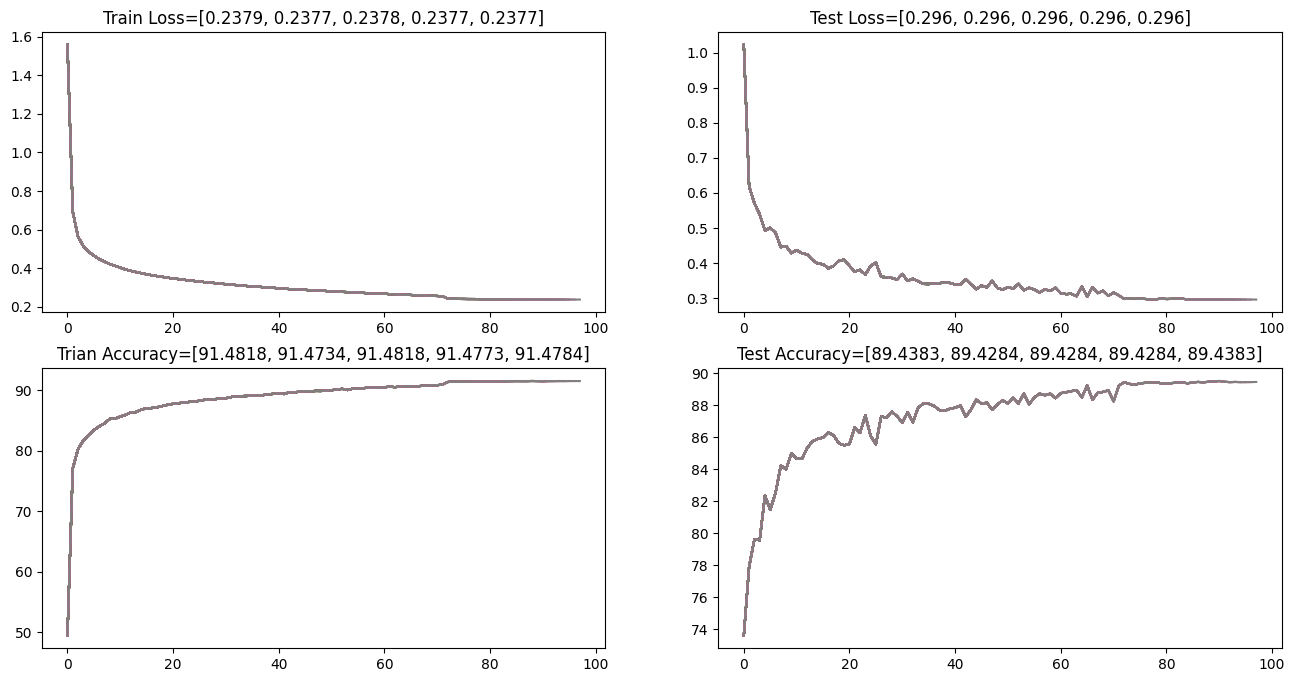

In [4]:
module = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 *28,64),
    nn.BatchNorm1d(num_features=64),
    nn.ReLU(),
    nn.Linear(64,16),
    nn.BatchNorm1d(num_features=16),
    nn.ReLU(),
    nn.Linear(16,len(train_data.classes)),
    #nn.Softmax(dim=1)
)

class CustomModelWithConv(nn.Module):
    def __init__(self, weight_decay=1e-4,dropout_prob=0.5):
        super(CustomModelWithConv, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(10 * 7 * 7, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(32, len(train_data.classes)),
            nn.ReLU()
        )

        # 添加L2正则化
        self.weight_decay = weight_decay

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

    
    def l2_regularization(self):
        l2_reg = torch.tensor(0.0).to(device)
        for param in self.parameters():
            if len(param.shape) > 1:  # 仅对权重矩阵应用 L2 正则化
                l2_reg += torch.norm(param, p='fro')  # 计算 Frobenius 范数
        return self.weight_decay * l2_reg
    
module = CustomModelWithConv()

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

module.apply(weights_init)
    
loss_fn = nn.CrossEntropyLoss()
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
#optimizer = torch.optim.Adam(params=module.parameters(),lr = 0.01, weight_decay=1e-4)
#optimizer = torch.optim.Adadelta(module.parameters(), lr=0.05, rho=0.9, eps=1e-6, weight_decay=1e-4)
optimizer = torch.optim.SGD(params=module.parameters(),lr = 0.01)
#scheduler = StepLR(optimizer, step_size=20, gamma=0.2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

from util import accuracy_fn,train_step,test_step



best_loss = float('inf')
patience= 10
current_patience = 0
epochs = 100
train_result = []
test_result = []

test_losses= []
test_accs = []
train_losses = []
train_accs = []

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw={'height_ratios': [1, 1]})
#plt.subplots_adjust(wspace=0.5, hspace=0.5)

for epoch in range(epochs):
    start_time = time.time()
    train_loss,train_acc = train_step(module=module,data_loader=train_loader,loss_fn=loss_fn,optimizer=optimizer,device=device,accuracy_fn=accuracy_fn)
    test_loss,test_acc = test_step(module=module,data_loader= test_loader,loss_fn= loss_fn,device=device,accuracy_fn=accuracy_fn)
    scheduler.step(test_loss)

    if test_loss < best_loss:
        best_loss = test_loss
        current_patience = 0
    else:
        current_patience += 1

    train_result.append((epoch,train_loss,train_acc))
    train_losses.append(train_loss.detach().cpu().numpy())
    #train_losses.append(train_loss.cpu())
    train_accs.append(train_acc)
    test_result.append((epoch,test_loss,test_acc))
    test_losses.append(test_loss.detach().cpu().numpy())
    test_accs.append(test_acc)

    clear_output(wait=True)
    ax1.plot(train_losses, )
    ax2.plot(test_losses, )
    ax3.plot(train_accs)
    ax4.plot(test_accs)
    ax1.set_title(f'Train Loss={[ np.round(item,4) for item in train_losses[-5:]]}')
    ax2.set_title(f'Test Loss={[ np.round(item,4) for item in test_losses[-5:]]}')
    ax3.set_title(f'Trian Accuracy={[ round(item,4) for item in train_accs[-5:]]}')
    ax4.set_title(f'Test Accuracy={[ round(item,4) for item in test_accs[-5:]]}')
    display(fig)
    end_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    print(f'-------epoch------:{epoch} time:{(end_time - start_time):.2f}s current_lr:{current_lr},current_patience:{current_patience}')
    for name, param in module.named_parameters():
        if param.grad is not None:
            print(f'Gradient for {name}: {param.grad.norm()}')
    if current_patience == patience:
        print(f'Early stopping! No improvement for {patience} consecutive epochs.')
        print(f"train loss:{[ np.round(item,4) for item in train_losses]}")
        print(f"test loss:{[ np.round(item,4) for item in test_losses]}")
        break

    if epoch % 10 == 0:
        print(f"last 10 loss:{[ np.round(item,4) for item in test_losses[-10:]]}")
plt.ioff()

In [5]:
epoch_lable,loss_lable,acc_lable = zip(*train_result)
loss_lable = [item.detach().cpu().numpy() for item in loss_lable]
plt.figure(figsize=(20, 4))
plt.plot(epoch_lable, loss_lable, label='Train Loss', marker='o')
#plt.plot(epoch_lable, acc_lable, label='Train acc', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [6]:
plt.figure(figsize=(20, 4))
plt.plot(epoch_lable, acc_lable, label='Train acc', marker='s')
plt.xlabel('Epoch')
plt.ylabel('ACC')
plt.legend()

In [7]:
test_epoch_lable,test_loss_lable,test_acc_lable = zip(*test_result)
test_loss_lable = [item.detach().cpu().numpy() for item in test_loss_lable]
plt.figure(figsize=(20, 4))
plt.plot(test_epoch_lable, test_loss_lable, label='Test Loss', marker='o')
#plt.plot(test_epoch_lable, test_acc_lable, label='Test acc', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [8]:
plt.figure(figsize=(20, 4))
#plt.plot(epoch_lable, loss_lable, label='Test Loss', marker='o')
plt.plot(test_epoch_lable, test_acc_lable, label='Test acc', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [9]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);


Image shape: torch.Size([1, 28, 28])


In [10]:
row, col = 4,4
figure = plt.figure(figsize=(9,9))
class_names = train_data.classes
for i in range(1,row* col+1):
    index = torch.randint(0,len(train_data),size=[1]).item()
    image, label = train_data[index]
    figure.add_subplot(row, col, i)
    plt.imshow(image.squeeze())
    plt.title(class_names[label])
    plt.axis(False);
    